In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
%matplotlib inline
sns.set_style("white")
pd.options.mode.chained_assignment = None

cwd = os.getcwd()
cwd = cwd.replace('\\Model_Performance&Feature_Engineering', '') 
path = cwd + '\Dataset'

def checkWeek(param):
    if 'w' in list(param):
        return False
    else:
        return True

def splitTenor(param):
    try:
        if 'm' in list(param):
            return int(param.split('m')[0])
        elif 'w' in list(param):
            return int(param.split('w')[0])
    except TypeError:
        pass
    
def interestRate(param):
    if param <= 0.0099:
        return 0.0099
    elif param <= 0.0129:
        return 0.0129
    else:
        return 0.0159

def paidRateModifier1(unpaid, paid, tenor, default): #This function is used to modify the unpaid count of borrower
    if default == 1:
        unpaid = tenor - paid
        return unpaid
    else:
        return unpaid

In [2]:
#Read Loan Status Data
loan_status = pd.read_csv(path + '\getLoanStatus_result.csv')
loan_status['max_unpaid_percentage'] = loan_status['max_unpaid_percentage'].fillna(0)
loan_status['days_late'] = loan_status['days_late'].fillna(0)
loan_status = loan_status[(loan_status['paid']>=0) & (loan_status['unpaid']>=0)]

In [3]:
#Modify some data inputs
loan_status = loan_status[loan_status['tenor'].apply(checkWeek)]
loan_status['tenor'] = loan_status['tenor'].apply(splitTenor)
loan_status['interest_rate'] = loan_status['interest_rate'].apply(interestRate)
loan_status['unpaid'] = loan_status.apply(lambda row: paidRateModifier1(row['unpaid'], row['paid'], row['tenor'], row['default']), axis = 1)

The number of unpaid will be modified to " tenor - (total number of payments made) " if a borrower is already marked as default. This is done so that unpaid rate can be increased to give more balance to the very high paid rate, making the data more sensitive towards the penalty of a borrower when they default their loans.

## Simulation of Expected Return for different Tenure Duration

In [4]:
loan_status['loanAmount'] = 1
loan_status['principal'] = loan_status['loanAmount']/loan_status['tenor']
loan_status['interest'] = loan_status['loanAmount']*loan_status['interest_rate']
loan_status['installment'] = loan_status['principal']+ loan_status['interest']

def listPaid(paid, installment, tenor):
    arr = [0] * tenor
    for i in range(0,int(paid)):
        arr[i] = installment
    return np.npv(.0058, arr)
loan_status['expectedReturnNPV'] = loan_status.apply(lambda row: listPaid(row['paid'], row['installment'], row['tenor']), axis = 1)     
loan_status['loss'] = loan_status['loanAmount'] - loan_status['expectedReturnNPV']

In [5]:
lossparam_3 = loan_status['loss'][(loan_status['default']==1) & (loan_status['tenor'] <= 3) & (loan_status['tenor'] == loan_status['paid'] + loan_status['unpaid'])].mean()
lossparam_6 = loan_status['loss'][(loan_status['default']==1) & (loan_status['tenor'] == 6) & (loan_status['tenor'] == loan_status['paid'] + loan_status['unpaid'])].mean()
lossparam_12 = loan_status['loss'][(loan_status['default']==1) & (loan_status['tenor'] == 12) & (loan_status['tenor'] == loan_status['paid'] + loan_status['unpaid'])].mean()
lossparam = loan_status['loss'][(loan_status['default']==1)].mean()
print("Expected Loss of 3 months tenure {} %".format(lossparam_3 * 100))
print("Expected Loss of 6 months tenure {} %".format(lossparam_6 * 100))
print("Expected Loss of 12 months tenure {} %".format(lossparam_12 * 100))
print("Average Expected Loss is {} %".format(lossparam * 100))

Expected Loss of 3 months tenure 34.94357783560782 %
Expected Loss of 6 months tenure 49.50242637020857 %
Expected Loss of 12 months tenure 45.679076549388554 %
Average Expected Loss is 45.81641978183239 %


In [6]:
gainparam_3 = loan_status['loss'][(loan_status['default']==1) & (loan_status['status']=='closed') & (loan_status['tenor']== 3)].mean()
gainparam_6 = loan_status['loss'][(loan_status['default']==1) & (loan_status['status']=='closed') & (loan_status['tenor']== 6)].mean()
gainparam_12 = loan_status['loss'][(loan_status['default']==1) & (loan_status['status']=='closed') & (loan_status['tenor']== 12)].mean()
gainparam = abs(loan_status['loss'][(loan_status['default']==1) & (loan_status['status']=='closed')].mean())
print("Expected Gain of 3 months tenure {} %".format(abs(gainparam_3 * 100)))
print("Expected Gain of 6 months tenure {} %".format(abs(gainparam_6 * 100)))
print("Expected Gain of 12 months tenure {} %".format(abs(gainparam_12 * 100)))
print("Average Expected Gain is {} %".format(abs(gainparam * 100)))

Expected Gain of 3 months tenure 3.272179372102868 %
Expected Gain of 6 months tenure 7.0857940484359005 %
Expected Gain of 12 months tenure 10.574739591747859 %
Average Expected Gain is 9.246325516746099 %


## Simulation of Threshold over NPV

This is a simulation to see which threshold to use to get the optimal NPV. The reason for this is because the optimal NPV is not gained by using the most accurate model, but to use a model that can minimize expected loss by choosing the threshold that can reject applicants more optimally.

In [7]:
def prediction(param):
    if param <= 0.2:
        return 0
    else:
        return 1

df = pd.read_csv(path + '\getModelPerformance.csv')
selected = ['application_id','loan_amount_new','loan_duration_new','installment_new','complaint_count_new','store_age_month_new','other_income','reputation_negative_new','fraud_npwp','is_preapproved','bank_statement','ktp','merchant_type','cashflow_slope_new','stable_rate_new','down_rate_new','trans_down_rate_new','dueAmount_new','outstandingAmount_new','grade_new','nDisbKTP','nDisbShop']
df = df[selected]
df = pd.merge(df, loan_status, on='application_id', how='inner')


#get the prediction result from DataRobot
result = pd.read_csv(path + '\dataset_for_model_performance_test_result.csv')
df = pd.merge(df, result[['application_id', 'Prediction']], on = 'application_id', how = 'left')
df = df[df['loan_amount_new'] >= 0]
df['Prediction'] = df['Prediction'].apply(prediction)

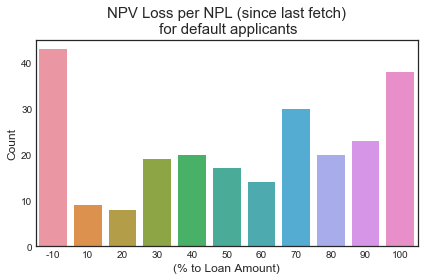

In [8]:
def cat(param):
    if param < 0:
        return -10
    elif param < 0.1:
        return 10
    elif param < 0.2:
        return 20
    elif param < 0.3:
        return 30
    elif param < 0.4:
        return 40
    elif param < 0.5:
        return 50
    elif param < 0.6:
        return 60
    elif param < 0.7:
        return 70
    elif param < 0.8:
        return 80
    elif param < 0.9:
        return 90
    elif param <= 1:
        return 100
    
df['loss_new'] = df['loss'].apply(cat)
df = df.dropna(thresh = 30)
fig = plt.figure()
sns.countplot(df['loss_new'][df['default']==1])
plt.title('NPV Loss per NPL (since last fetch)\n for default applicants', fontsize =  15)
plt.xlabel("(% to Loan Amount)", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.tight_layout()

In [9]:
ml_result = pd.read_csv(path + '\ML_CV.csv', sep=',')
ml_result['NPVLoss'] = ml_result['False Negative Scores'] * lossparam
ml_result['NPVGain'] = ml_result['True Negative Scores'] * gainparam
ml_result['NPV'] = (ml_result['NPVGain'] - ml_result['NPVLoss'])
ml_result['Excess Return'] = ml_result['NPV']*100/(ml_result['False Negative Scores'] + ml_result['True Negative Scores'])

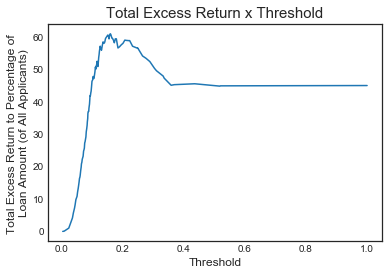

In [10]:
fig = plt.figure()
plt.plot(ml_result['Threshold'], ml_result['NPV'])
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Total Excess Return to Percentage of \nLoan Amount (of All Applicants)', fontsize=12)
plt.title('Total Excess Return x Threshold', fontsize=15)
plt.show()

# fig = plt.figure()
# plt.plot(ml_result['Threshold'], ml_result['Excess Return'])
# plt.xlabel('Threshold', fontsize=12)
# plt.ylabel('Excess Return/Applicant to Loan Amount \n(of an applicant)', fontsize=12)
# plt.title('Excess Return/Applicants x Threshold', fontsize=15)
# plt.show()

The optimal threshold that our model should be using is taken from the peak of the graph above, which is approximately 0.2. This calculated threshold is different from the threshold that DataRobot recommends (around 0.1794), therefore, it is recommended for the business to choose this threshold to optimize the profits that can be gained each month. 

In [11]:
ml_result

Accuracy        F1  False Negative Scores  True Negative Scores  \
0    0.880307  0.000000                    203                  1493   
1    0.879717  0.000000                    203                  1492   
2    0.879127  0.000000                    203                  1491   
3    0.879127  0.019139                    201                  1489   
4    0.877358  0.018868                    201                  1486   
5    0.876179  0.018692                    201                  1484   
6    0.878538  0.063636                    196                  1483   
7    0.877948  0.080000                    194                  1480   
8    0.876769  0.118143                    189                  1473   
9    0.876769  0.132780                    187                  1471   
10   0.876179  0.173228                    181                  1464   
11   0.875590  0.191571                    178                  1460   
12   0.873231  0.206642                    175                  1453   
13   0.872642  0.244755                    168                  1445   
14   0.872052  0.243902                    168                  1444   
15   0.866745  0.256579                    164                  1431   
16   0.866156  0.279365                    159                  1425   
17   0.863797  0.280374                    158                  1420   
18   0.857311  0.284024                    155                  1406   
19   0.850825  0.287324                    152                  1392   
20   0.841981  0.279570                    151                  1376   
21   0.837854  0.278215                    150                  1368   
22   0.833726  0.276923                    149                  1360   
23   0.826061  0.275184                    147                  1345   
24   0.818986  0.274232                    145                  1331   
25   0.818396  0.300000                    137                  1322   
26   0.811321  0.301310                    134                  1307   
27   0.801297  0.293501                    133                  1289   
28   0.798939  0.299795                    130                  1282   
29   0.795991  0.302419                    128                  1275   
..        ...       ...                    ...                   ...   
86   0.364387  0.244039                     29                   444   
87   0.356722  0.243936                     27                   429   
88   0.346698  0.241096                     27                   412   
89   0.339033  0.241029                     25                   397   
90   0.331368  0.240964                     23                   382   
91   0.321344  0.238253                     23                   365   
92   0.313679  0.238220                     21                   350   
93   0.306014  0.238188                     19                   335   
94   0.297759  0.237028                     18                   320   
95   0.290094  0.237009                     16                   305   
96   0.281250  0.235737                     15                   289   
97   0.272406  0.234491                     14                   273   
98   0.262382  0.232044                     14                   256   
99   0.254717  0.232078                     12                   241   
100  0.247052  0.232111                     10                   226   
101  0.238208  0.230952                      9                   210   
102  0.229953  0.229953                      8                   195   
103  0.221108  0.228838                      7                   179   
104  0.212264  0.227746                      6                   163   
105  0.204599  0.227819                      4                   148   
106  0.195755  0.226757                      3                   132   
107  0.186910  0.225716                      2                   116   
108  0.176887  0.223582                      2                    99   
109  0.168042  0.222590                      